Regression Model- NYC Crimes 2013

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, read_csv
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statistics
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as smf

from statsmodels.sandbox.regression.predstd import wls_prediction_std

from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
df = pd.read_excel('nyc_offenses_2013.xls')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 13 columns):
City                                    348 non-null object
Population                              348 non-null int64
Violent
crime                           348 non-null int64
Murder and
nonnegligent
manslaughter    348 non-null int64
Rape
(revised
definition)1              0 non-null float64
Rape
(legacy
definition)2               348 non-null int64
Robbery                                 348 non-null int64
Aggravated
assault                      348 non-null int64
Property
crime                          348 non-null int64
Burglary                                348 non-null int64
Larceny-
theft                          348 non-null int64
Motor
vehicle
theft                     348 non-null int64
Arson3                                  187 non-null float64
dtypes: float64(2), int64(10), object(1)
memory usage: 34.0+ KB


In [4]:
df.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,1861,0,0,nan,0,0,0,12,2,10,0,0.000
1,Addison Town and Village,2577,3,0,nan,0,0,3,24,3,20,1,0.000
2,Akron Village,2846,3,0,nan,0,0,3,16,1,15,0,0.000
3,Albany,97956,791,8,nan,30,227,526,4090,705,3243,142,nan
4,Albion Village,6388,23,0,nan,3,4,16,223,53,165,5,nan


In [5]:
df.isnull().sum()

City                                        0
Population                                  0
Violent\ncrime                              0
Murder and\nnonnegligent\nmanslaughter      0
Rape\n(revised\ndefinition)1              348
Rape\n(legacy\ndefinition)2                 0
Robbery                                     0
Aggravated\nassault                         0
Property\ncrime                             0
Burglary                                    0
Larceny-\ntheft                             0
Motor\nvehicle\ntheft                       0
Arson3                                    161
dtype: int64

In [6]:
df.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3'],
      dtype='object')

In [7]:
df.rename(columns={'Murder and\nnonnegligent\nmanslaughter':'Murder'}, inplace=True)
df.rename(columns={'Rape\n(revised\ndefinition)1':'rape1'}, inplace=True)
df.rename(columns={'Rape\n(legacy\ndefinition)2':'rape2'}, inplace=True)
df.rename(columns={'Aggravated\nassault':'agg_assault'}, inplace=True)
df.rename(columns={'Violent\ncrime':'violent_crime'}, inplace=True)
df.rename(columns={'Property\ncrime':'property_crime'}, inplace=True)
df.rename(columns={'Larceny-\ntheft':'larceny'}, inplace=True)
df.rename(columns={'Motor\nvehicle\ntheft':'vehicle_theft'}, inplace=True)

In [8]:
# Convert all columns to lower case.

df.columns = map(str.lower, df.columns)

In [9]:
df.drop('rape1', axis=1, inplace=True)

In [10]:
df.arson3.describe()

count   187.000
mean      1.872
std      10.693
min       0.000
25%       0.000
50%       0.000
75%       1.000
max     132.000
Name: arson3, dtype: float64

In [11]:
# Replace arson3 NaN with mean
df.fillna(value=2, inplace=True)

In [12]:
df.columns

Index(['city', 'population', 'violent_crime', 'murder', 'rape2', 'robbery',
       'agg_assault', 'property_crime', 'burglary', 'larceny', 'vehicle_theft',
       'arson3'],
      dtype='object')

In [13]:
df.isnull().sum()

city              0
population        0
violent_crime     0
murder            0
rape2             0
robbery           0
agg_assault       0
property_crime    0
burglary          0
larceny           0
vehicle_theft     0
arson3            0
dtype: int64

In [14]:
df['population_sq'] = df['population']*df['population']

In [15]:
# Initial instrucions were to make murder and robbery continuous variables into categorical.  Full model excludes this.

# df.Murder[df.Murder>0] = 1
# df.Robbery[df.Robbery>0] = 1

In [16]:
df.dtypes

city               object
population          int64
violent_crime       int64
murder              int64
rape2               int64
robbery             int64
agg_assault         int64
property_crime      int64
burglary            int64
larceny             int64
vehicle_theft       int64
arson3            float64
population_sq       int64
dtype: object

In [17]:
df.describe()

,population,violent_crime,murder,rape2,robbery,agg_assault,property_crime,burglary,larceny,vehicle_theft,arson3,population_sq
count,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000
mean,40037.632,201.595,1.566,5.865,72.902,121.261,792.606,119.684,637.017,35.905,1.931,203554650960.236
std,450037.368,2815.269,18.304,60.425,1031.033,1706.132,7659.725,924.949,6346.054,403.424,7.829,3778875542708.129
min,526.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,276676.000
25%,3003.000,2.000,0.000,0.000,0.000,1.000,40.500,6.000,31.000,0.000,0.000,9018117.000
50%,7233.500,6.000,0.000,0.000,1.000,4.000,112.500,17.500,94.000,2.000,2.000,52325684.500
75%,18427.500,22.000,0.000,2.000,5.000,14.000,341.000,51.250,287.250,7.000,2.000,339753567.000
max,8396126.000,52384.000,335.000,1112.000,19170.000,31767.000,141971.000,16606.000,117931.000,7434.000,132.000,70494931807876.000


In [18]:
df.population.describe()

count       348.000
mean      40037.632
std      450037.368
min         526.000
25%        3003.000
50%        7233.500
75%       18427.500
max     8396126.000
Name: population, dtype: float64

Text(0,0.5,'population')

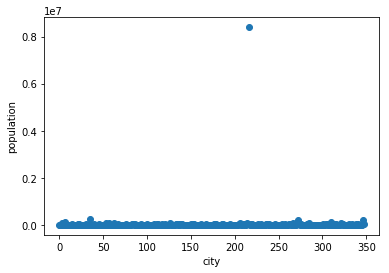

In [19]:
plt.scatter(x=df.index, y="population", data=df)
plt.xlabel('city')
plt.ylabel('population')

In [20]:
df = df[df.city != 'New York']

In [21]:
df.population.describe()

count      347.000
mean     15956.686
std      27080.219
min        526.000
25%       2997.000
50%       7187.000
75%      18160.500
max     258789.000
Name: population, dtype: float64

Text(0,0.5,'population')

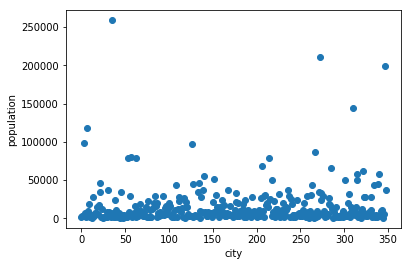

In [22]:
plt.scatter(x=df.index, y="population", data=df)
plt.xlabel('city')
plt.ylabel('population')

In [23]:
df.head()

,city,population,violent_crime,murder,rape2,robbery,agg_assault,property_crime,burglary,larceny,vehicle_theft,arson3,population_sq
0,Adams Village,1861,0,0,0,0,0,12,2,10,0,0.000,3463321
1,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,0.000,6640929
2,Akron Village,2846,3,0,0,0,3,16,1,15,0,0.000,8099716
3,Albany,97956,791,8,30,227,526,4090,705,3243,142,2.000,9595377936
4,Albion Village,6388,23,0,3,4,16,223,53,165,5,2.000,40806544


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347 entries, 0 to 347
Data columns (total 13 columns):
city              347 non-null object
population        347 non-null int64
violent_crime     347 non-null int64
murder            347 non-null int64
rape2             347 non-null int64
robbery           347 non-null int64
agg_assault       347 non-null int64
property_crime    347 non-null int64
burglary          347 non-null int64
larceny           347 non-null int64
vehicle_theft     347 non-null int64
arson3            347 non-null float64
population_sq     347 non-null int64
dtypes: float64(1), int64(11), object(1)
memory usage: 36.6+ KB


In [25]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df['property_crime']
X = df[['population', 'population_sq', 'murder', 'robbery']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared: \n', regr.score(X, Y))


Coefficients: 
 [ 2.05519792e-02 -7.19468320e-08  1.02643383e+02  5.13001360e+00]

Intercept: 
 -25.039858198830643

R-squared: 
 0.939283140822447


In [26]:
Y = df['property_crime'].values.reshape(-1, 1)

min_max_scaler = preprocessing.MinMaxScaler()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.transform(X_test)
Y_train_minmax = min_max_scaler.fit_transform(Y_train)
Y_test_minmax = min_max_scaler.transform(Y_test)


c:\users\will\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [27]:
# Scale data

regr.fit(X_train_minmax, Y_train_minmax) 

print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print(regr.score(X_train_minmax, Y_train_minmax))

Coefficients: 
 [[ 0.44721463 -0.4727676   0.30173514  0.69853632]]
Intercept: 
 [-0.00157959]
0.9455090702796195


In [28]:
# Scale data

regr.fit(X_test_minmax, Y_test_minmax) 

print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print(regr.score(X_test_minmax, Y_test_minmax))

Coefficients: 
 [[0.27079562 0.2205344  0.73509005 0.17283849]]
Intercept: 
 [0.00121973]
0.810130050514219


In [29]:
regr.fit(X_train, Y_train)

print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print(regr.score(X_train, Y_train))

Coefficients: 
 [[ 2.16297262e-02 -8.81769528e-08  8.01909276e+01  6.60016430e+00]]
Intercept: 
 [-31.08349863]
0.9455090702796194


In [30]:
regr.fit(X_test, Y_test)

print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print(regr.score(X_test, Y_test))

Coefficients: 
 [[1.30971457e-02 4.11323690e-08 1.95361911e+02 1.63307532e+00]]
Intercept: 
 [8.33518736]
0.810130050514219


In [31]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df['property_crime']
X = df[['population', 'population_sq', 'murder', 'robbery', 'violent_crime', 'rape2', 'agg_assault', \
        'burglary', 'larceny', 'vehicle_theft', 'arson3']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared: \n', regr.score(X, Y))


Coefficients: 
 [ 3.33538163e-15 -1.44869104e-19 -5.04355970e-15 -1.86376442e-16
 -1.11034344e-14 -1.75087507e-14  1.17033404e-14  1.00000000e+00
  1.00000000e+00  1.00000000e+00 -9.24667766e-17]

Intercept: 
 8.986944521893747e-11

R-squared: 
 1.0


In [32]:
X1 = df[['population', 'population_sq']]

In [33]:
X1.head()

,population,population_sq
0,1861,3463321
1,2577,6640929
2,2846,8099716
3,97956,9595377936
4,6388,40806544


In [34]:
X2 = smf.add_constant(X1)
est = smf.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     900.8
Date:                Wed, 27 Jun 2018   Prob (F-statistic):          1.82e-137
Time:                        13:29:54   Log-Likelihood:                -2583.0
No. Observations:                 347   AIC:                             5172.
Df Residuals:                     344   BIC:                             5184.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            14.9016     30.445      0.489

In [35]:
X3 = df[['property_crime','population', 'population_sq', 'murder', 'robbery', 'violent_crime', 'rape2', 'agg_assault', \
        'burglary', 'larceny', 'vehicle_theft', 'arson3']]

In [36]:
X3.corr()

,property_crime,population,population_sq,murder,robbery,violent_crime,rape2,agg_assault,burglary,larceny,vehicle_theft,arson3
property_crime,1.000,0.887,0.893,0.917,0.933,0.944,0.949,0.942,0.977,0.995,0.949,0.630
population,0.887,1.000,0.889,0.756,0.816,0.829,0.797,0.835,0.820,0.901,0.828,0.518
population_sq,0.893,0.889,1.000,0.884,0.940,0.935,0.888,0.926,0.893,0.873,0.938,0.535
murder,0.917,0.756,0.884,1.000,0.963,0.955,0.946,0.938,0.956,0.881,0.959,0.677
robbery,0.933,0.816,0.940,0.963,1.000,0.994,0.949,0.983,0.964,0.898,0.989,0.586
violent_crime,0.944,0.829,0.935,0.955,0.994,1.000,0.962,0.997,0.971,0.913,0.987,0.573
rape2,0.949,0.797,0.888,0.946,0.949,0.962,1.000,0.958,0.974,0.921,0.960,0.577
agg_assault,0.942,0.835,0.926,0.938,0.983,0.997,0.958,1.000,0.964,0.913,0.977,0.553
burglary,0.977,0.820,0.893,0.956,0.964,0.971,0.974,0.964,1.000,0.950,0.976,0.640
larceny,0.995,0.901,0.873,0.881,0.898,0.913,0.921,0.913,0.950,1.000,0.916,0.620


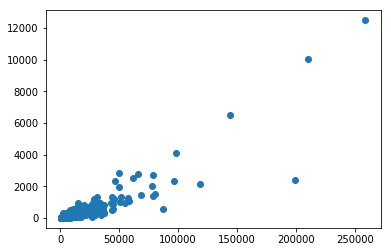

In [37]:
plt.scatter(df.population, df.property_crime)
plt.show()

In [38]:
X4 = smf.add_constant(X3)
est3 = smf.OLS(Y, X4)
est4 = est3.fit()
print(est4.summary())

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.167e+21
Date:                Wed, 27 Jun 2018   Prob (F-statistic):               0.00
Time:                        13:29:54   Log-Likelihood:                 4905.9
No. Observations:                 347   AIC:                            -9790.
Df Residuals:                     336   BIC:                            -9747.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            1.21e-07   1.33e-08      9.

In [39]:
X.head()

,population,population_sq,murder,robbery,violent_crime,rape2,agg_assault,burglary,larceny,vehicle_theft,arson3
0,1861,3463321,0,0,0,0,0,2,10,0,0.000
1,2577,6640929,0,0,3,0,3,3,20,1,0.000
2,2846,8099716,0,0,3,0,3,1,15,0,0.000
3,97956,9595377936,8,227,791,30,526,705,3243,142,2.000
4,6388,40806544,0,4,23,3,16,53,165,5,2.000


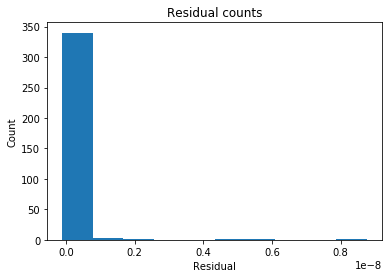

In [40]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = df['property_crime']

# Calculate the error, also called the residual.
residual = actual - predicted

plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

In [41]:
X.corr() 

,population,population_sq,murder,robbery,violent_crime,rape2,agg_assault,burglary,larceny,vehicle_theft,arson3
population,1.000,0.889,0.756,0.816,0.829,0.797,0.835,0.820,0.901,0.828,0.518
population_sq,0.889,1.000,0.884,0.940,0.935,0.888,0.926,0.893,0.873,0.938,0.535
murder,0.756,0.884,1.000,0.963,0.955,0.946,0.938,0.956,0.881,0.959,0.677
robbery,0.816,0.940,0.963,1.000,0.994,0.949,0.983,0.964,0.898,0.989,0.586
violent_crime,0.829,0.935,0.955,0.994,1.000,0.962,0.997,0.971,0.913,0.987,0.573
rape2,0.797,0.888,0.946,0.949,0.962,1.000,0.958,0.974,0.921,0.960,0.577
agg_assault,0.835,0.926,0.938,0.983,0.997,0.958,1.000,0.964,0.913,0.977,0.553
burglary,0.820,0.893,0.956,0.964,0.971,0.974,0.964,1.000,0.950,0.976,0.640
larceny,0.901,0.873,0.881,0.898,0.913,0.921,0.913,0.950,1.000,0.916,0.620
vehicle_theft,0.828,0.938,0.959,0.989,0.987,0.960,0.977,0.976,0.916,1.000,0.581


The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [1.00000000e+00 6.01122781e-12 3.89798907e-15 2.73673680e-16]


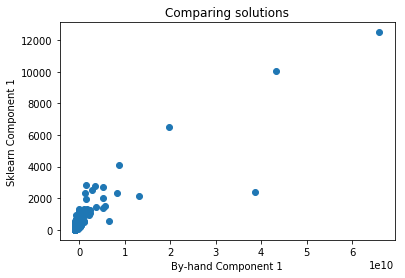

In [42]:
sklearn_pca = PCA(n_components=4)
Y_sklearn = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# Compare the sklearn solution to ours
plt.plot(Y_sklearn[:, 0], Y, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()

In [43]:
X5 = df[['population','population_sq', 'murder', 'robbery', 'violent_crime']]

In [44]:
X5.head()

,population,population_sq,murder,robbery,violent_crime
0,1861,3463321,0,0,0
1,2577,6640929,0,0,3
2,2846,8099716,0,0,3
3,97956,9595377936,8,227,791
4,6388,40806544,0,4,23


In [45]:
X6 = smf.add_constant(X5)
est5 = smf.OLS(Y, X6)
est6 = est5.fit()
print(est6.summary())

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     1186.
Date:                Wed, 27 Jun 2018   Prob (F-statistic):          3.68e-213
Time:                        13:31:07   Log-Likelihood:                -2395.4
No. Observations:                 347   AIC:                             4803.
Df Residuals:                     341   BIC:                             4826.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -19.2328     17.912     -1.074